🙏 This notebook builds off of the work of @greysky's [Enefit Generic Notebook](https://www.kaggle.com/code/greysky/enefit-generic-notebook) and @patrick0302's [Do you desire sun power](https://www.kaggle.com/code/patrick0302/do-you-desire-sun-power)

We will build two models, one for energy production and one for energy consumption, and build our prediction from the output of these two.

In [1]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor

import lightgbm as lgb

import optuna

/venv-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MonthlyKFold:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
        
    def split(self, X, y, groups=None):
        dates = 12 * X["year"] + X["month"]
        timesteps = sorted(dates.unique().tolist())
        X = X.reset_index()
        
        for t in timesteps[-self.n_splits:]:
            idx_train = X[dates.values < t].index
            idx_test = X[dates.values == t].index
            
            yield idx_train, idx_test
            
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [3]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        )
    )
    
    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )
    
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
#             pl.col('datetime').dt.convert_time_zone("Europe/Bucharest").dt.replace_time_zone(None).cast(pl.Datetime("us")),
            pl.col('datetime').dt.replace_time_zone(None).cast(pl.Datetime("us"))
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")
        
        .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_fdw")
        .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_flw")
        .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_hdw")
        .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_hlw")
        
        # .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=1)).rename({"target": "target_1"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "target_2"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "target_3"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=4)).rename({"target": "target_4"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=5)).rename({"target": "target_5"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=6)).rename({"target": "target_6"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "target_7"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=14)).rename({"target": "target_14"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        # .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=21)).rename({"target": "target_21"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        # .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=28)).rename({"target": "target_28"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        )
        
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("day") / 15).sin().alias("sin(dayofmonth)"),
            (np.pi * pl.col("day") / 15).cos().alias("cos(dayofmonth)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("date", "datetime", "hour", "day", "dayofyear")
    )
    
    return df_data

In [4]:
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "category_1"]
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    df["target_mean"] = df[[f"target_{i}" for i in range(2, 7)]].mean(1)
    df["target_std"] = df[[f"target_{i}" for i in range(2, 7)]].std(1)
    df["target_ratio_7"] = df["target_7"] / (df["target_14"] + 1e-3)
    # df["target_ratio_14"] = df["target_14"] / (df["target_28"] + 1e-3)
    
    # df.drop([f"target_{i}" for i in range(2, 7)], axis=1, inplace=True)
    # df.drop([f"target_{i}" for i in [1, 3, 4, 5, 6]], axis=1, inplace=True)
    # df.drop(["county", "is_business", "product_type"], axis=1, inplace=True)

    return df

In [5]:
def lgb_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l1',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 256),
        'max_depth'        : trial.suggest_int('max_depth', 5, 10),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
        'num_leaves'       : trial.suggest_int('num_leaves', 16, 128),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train[df_train['is_consumption']==0].drop(columns=["target"]), df_train[df_train['is_consumption']==0]["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)

In [6]:
# Utility cell to transfer between local and online notebook runs
root = "competition_data"
# root = "/kaggle/input/predict-energy-behavior-of-prosumers"

To kick things off, we begin by performing a pivoting operation on the training data to obtain distinct time series.

In [7]:
train = pd.read_csv(os.path.join(root, "train.csv"))

# Pivot the training data to have a cleaner DataFrame where we can analyze the mean target values
# organized by datetime and various categorical variables.
pivot_train = train.pivot_table(index='datetime',columns=['county','product_type','is_business','is_consumption'], values='target', aggfunc='mean')

# Renaming columns for easier access and interpretation
pivot_train.columns = ['county{}_productType{}_isBusiness{}_isConsumption{}'.format(*col) for col in pivot_train.columns.values]
pivot_train.index = pd.to_datetime(pivot_train.index)

pivot_train

,county0_productType0_isBusiness1_isConsumption0,county0_productType0_isBusiness1_isConsumption1,county0_productType1_isBusiness0_isConsumption0,county0_productType1_isBusiness0_isConsumption1,county0_productType1_isBusiness1_isConsumption0,county0_productType1_isBusiness1_isConsumption1,county0_productType2_isBusiness0_isConsumption0,county0_productType2_isBusiness0_isConsumption1,county0_productType2_isBusiness1_isConsumption0,county0_productType2_isBusiness1_isConsumption1,...,county15_productType0_isBusiness1_isConsumption0,county15_productType0_isBusiness1_isConsumption1,county15_productType1_isBusiness0_isConsumption0,county15_productType1_isBusiness0_isConsumption1,county15_productType1_isBusiness1_isConsumption0,county15_productType1_isBusiness1_isConsumption1,county15_productType3_isBusiness0_isConsumption0,county15_productType3_isBusiness0_isConsumption1,county15_productType3_isBusiness1_isConsumption0,county15_productType3_isBusiness1_isConsumption1
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.000,59.000,0.713,96.590,0.000,501.760,0.000,17.314,NaN,NaN,...,NaN,NaN,0.000,5.524,0.100,17.703,0.000,59.366,0.000,289.159
2021-09-01 01:00:00,0.000,61.600,1.132,77.691,0.000,486.297,0.000,15.872,NaN,NaN,...,NaN,NaN,0.000,4.632,0.100,20.416,0.000,56.357,0.000,280.657
2021-09-01 02:00:00,0.000,63.100,0.490,91.594,0.000,458.562,0.000,16.510,NaN,NaN,...,NaN,NaN,0.000,5.461,0.100,27.440,0.000,51.038,0.000,295.537
2021-09-01 03:00:00,0.000,64.000,0.496,87.955,0.000,511.794,0.000,14.271,NaN,NaN,...,NaN,NaN,0.000,4.617,0.000,19.050,0.000,48.482,0.000,287.724
2021-09-01 04:00:00,0.000,60.500,0.149,88.184,0.000,520.318,0.000,18.225,NaN,NaN,...,NaN,NaN,0.000,4.578,0.100,21.228,0.000,57.115,0.000,286.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 19:00:00,45.516,592.897,439.610,300.096,126.947,761.060,3.346,2.978,5.709,11.249,...,20.147,530.777,26.074,27.369,59.005,13.353,124.516,65.457,111.403,171.252
2023-05-31 20:00:00,12.259,586.746,120.856,443.340,27.563,827.122,0.792,2.730,1.546,14.582,...,8.649,537.154,19.584,35.140,25.563,13.756,43.101,85.693,43.751,232.759
2023-05-31 21:00:00,1.984,544.978,22.428,569.301,5.091,808.137,0.136,3.997,0.304,19.392,...,1.260,323.350,1.804,52.427,2.840,24.250,6.982,124.146,7.030,265.328


Upon visualizing the data for the past year, with daily average values plotted, an intriguing pattern emerges among the 138 time series. They can be classified into two distinct groups based on their trends — either an upward trajectory or a downward one.

As you may have already knew, the upward-trending series predominantly represent energy consumption, while the downward-trending ones are mostly energy production, specifically solar power generation.

<Axes: xlabel='datetime'>

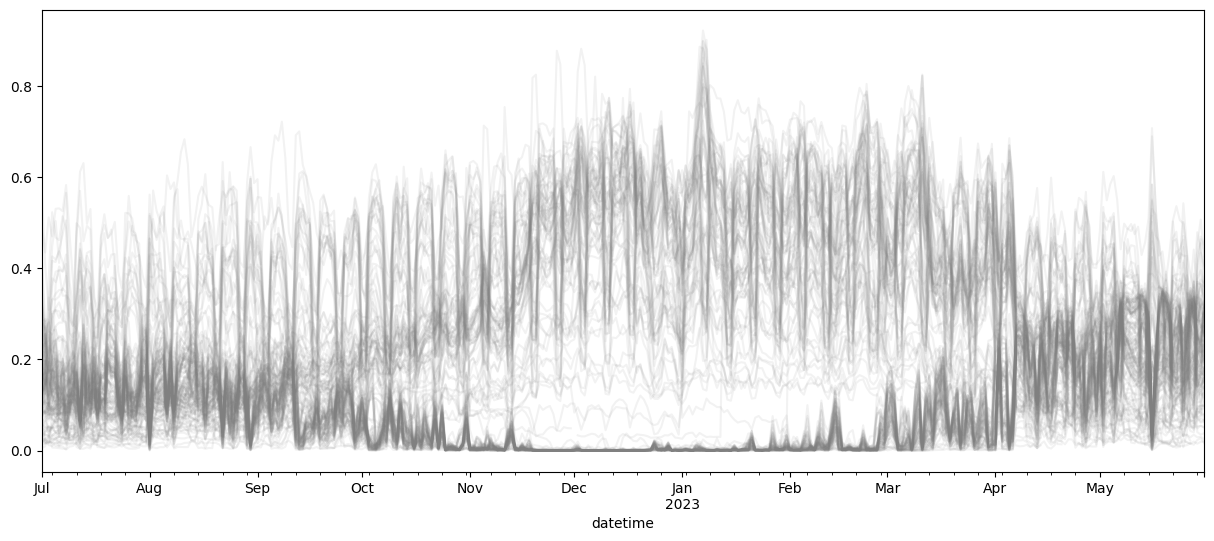

In [8]:
df_plot = pivot_train.copy()
df_plot = (df_plot - df_plot.min())/(df_plot.max() - df_plot.min())
df_plot_resampled_D = df_plot.resample('D').mean()

# Plot the consumption data with alpha=0.1 
df_plot_resampled_D.loc['2022-7':].plot(alpha=0.1, color='gray', figsize=(15, 6), legend=False)

If we color these time series using the values from the `is_consumption` variable, with 0 denoting green and 1 representing blue, it becomes evident that the **green lines consistently align with solar radiation**, as illustrated in the subsequent plot.

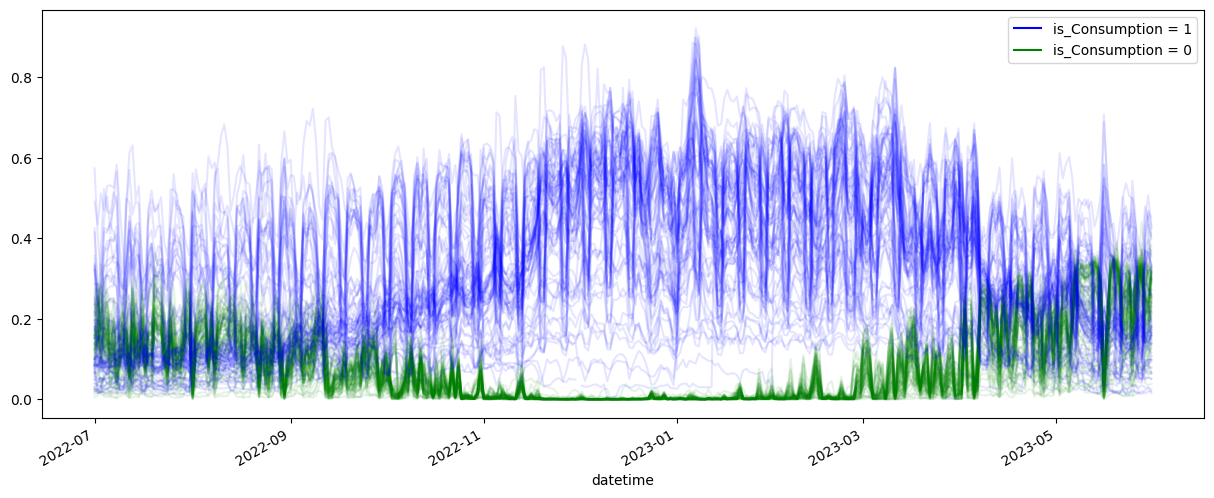

In [9]:
# Select the relevant columns and time range
columns_consumption_0 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption0')]
columns_consumption_1 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption1')]

# Create a single legend for each category
plt.figure(figsize=(15, 6))
plt.plot([], color='blue', label='is_Consumption = 1')
plt.plot([], color='green', label='is_Consumption = 0')
plt.legend()

# Plot the data for is_Consumption = 0 in green
for column in columns_consumption_0:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='green', legend=False)

# Plot the data for is_Consumption = 1 in blue
for column in columns_consumption_1:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='blue', legend=False)

# Add a single legend to the plot
#plt.legend()

# Show the plot
plt.show()

This forms the foundation of our hypothesis that developing a separate model for energy production data could be beneficial, given the distinct characteristics of energy production when compared to consumption.

The subsequent code modifications involve the introduction of a new lightGBM model for production data (where df_train["is_consumption"] == 0), and the replacement of the production predictions with the new solar model's output in the final submission, while all other prediction values remain the same with the original model.

# Do you feel the sun power? 😎

In [10]:
data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

save_path = None # "trained_gbm_models_20231213.pkl"
load_path = None # "trained_gbm_models.pkl"

In [11]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema

### Feature Engineering

In [ ]:
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)

In [ ]:
df_train = df_train[df_train["target"].notnull() & (df_train["year"].gt(2022) | (df_train["year"].eq(2022) & df_train["month"].gt(5)))]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170068 entries, 848016 to 2018351
Columns: 138 entries, county to target_ratio_7
dtypes: category(5), float32(128), float64(2), int32(1), uint32(2)
memory usage: 618.2 MB


### HyperParam Optimization

Note: Optuna on my local machine takes about 3min 30sec per iteration!

In [ ]:
study = optuna.create_study(direction='minimize', study_name='Regressor')
study.optimize(lgb_objective, n_trials=10, show_progress_bar=True)

In [16]:
best_params = {
    'n_iter'           : 1000,
    'verbose'          : -1,
    'objective'        : 'l1',
    'learning_rate'    : 0.05, 
    'colsample_bytree' : 0.85, 
    'colsample_bynode' : 0.50, 
    'lambda_l1'        : 7.0, 
    'lambda_l2'        : 8.5, 
    'min_data_in_leaf' : 60, 
    'max_depth'        : 10, 
    'max_bin'          : 200,
    'num_leaves'       : 90
} # cross_val_score is about 46.3 based on Optuna outputs; evaluation below is about 46.8
best_params_solar = {
    'n_iter'           : 1000,
    'verbose'          : -1,
    'objective'        : 'l1',
    'learning_rate'    : 0.10, 
    'colsample_bytree' : 0.625, 
    'colsample_bynode' : 0.77, 
    'lambda_l1'        : 5.0, 
    'lambda_l2'        : 0.0, 
    'min_data_in_leaf' : 200, 
    'max_depth'        : 7, 
    'max_bin'          : 800,
    'num_leaves'       : 80
} # cross_val_score is about 74.5 based on Optuna outputs; evaluation below is about 75.8

### Validation

Fit and evaluation time is about 3min 30sec on my machine.

In [17]:
result = cross_validate(
    estimator=lgb.LGBMRegressor(**best_params, random_state=42),
    X=df_train[df_train['is_consumption']==1].drop(columns=["target"]), 
    y=df_train[df_train['is_consumption']==1]["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

result_solar = cross_validate(
    estimator=lgb.LGBMRegressor(**best_params_solar, random_state=42),
    X=df_train[df_train['is_consumption']==0].drop(columns=["target"]), 
    y=df_train[df_train['is_consumption']==0]["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

print(f"Fit Time(s): {result['fit_time'].mean():.3f}")
print(f"Score Time(s): {result['score_time'].mean():.3f}")
print(f"Error(MAE): {-result['test_score'].mean():.3f}")

print(f"Fit Time(s): {result_solar['fit_time'].mean():.3f}")
print(f"Score Time(s): {result_solar['score_time'].mean():.3f}")
print(f"Error(MAE): {-result_solar['test_score'].mean():.3f}")

/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fit Time(s): 196.839
Score Time(s): 4.064
Error(MAE): 48.662
Fit Time(s): 177.374
Score Time(s): 3.588
Error(MAE): 77.558


### Training

In [22]:
if load_path is not None:
    load_solar_path = "_solar.".join(load_path.split("."))
    model = pickle.load(open(load_path, "rb"))
    model_solar = pickle.load(open(load_solar_path, "rb"))
else:
    model = VotingRegressor([
        ('lgb_1', lgb.LGBMRegressor(**best_params, random_state=100)), 
        ('lgb_2', lgb.LGBMRegressor(**best_params, random_state=101)), 
        ('lgb_3', lgb.LGBMRegressor(**best_params, random_state=102)), 
        # ('lgb_4', lgb.LGBMRegressor(**best_params, random_state=103)), 
        # ('lgb_5', lgb.LGBMRegressor(**best_params, random_state=104)), 
    ])
    
    model_solar = VotingRegressor([
        ('lgb_6', lgb.LGBMRegressor(**best_params_solar, random_state=105)), 
        ('lgb_7', lgb.LGBMRegressor(**best_params_solar, random_state=106)), 
        ('lgb_8', lgb.LGBMRegressor(**best_params_solar, random_state=107)), 
        # ('lgb_9', lgb.LGBMRegressor(**best_params_solar, random_state=108)), 
        # ('lgb_10', lgb.LGBMRegressor(**best_params_solar, random_state=109)), 
    ])
    
    model.fit(
        X=df_train[df_train['is_consumption']==1].drop(columns=["target"]),
        y=df_train[df_train['is_consumption']==1]["target"]
    )
    
    model_solar.fit(
        X=df_train[df_train['is_consumption']==0].drop(columns=["target"]),
        y=df_train[df_train['is_consumption']==0]["target"]
    )

if save_path is not None:
    save_solar_path = "_solar.".join(save_path.split("."))
    with open(save_path, "wb") as f:
        pickle.dump(model, f)
    with open(save_solar_path, "wb") as f:
        pickle.dump(model_solar, f)

/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warnin

### Model Analysis

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

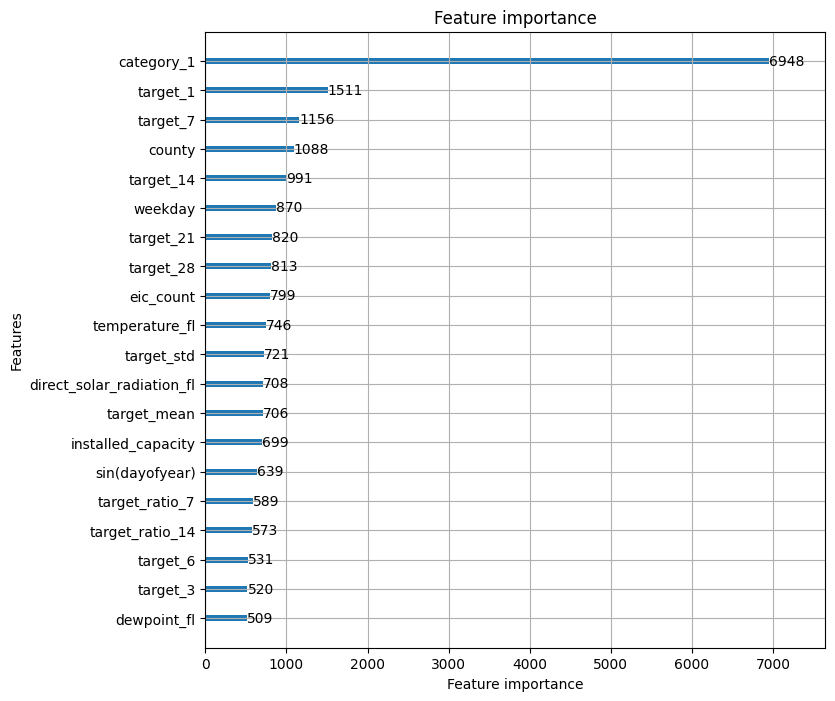

In [23]:
lgb.plot_importance(model.estimators_[0], max_num_features=20, figsize=(8, 8))

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

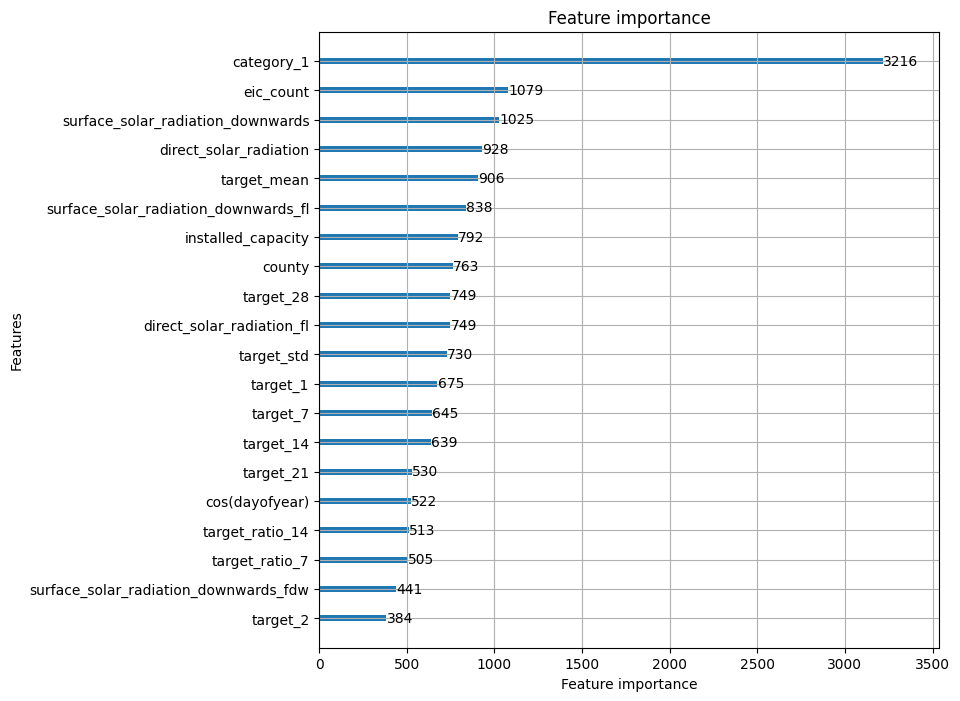

In [24]:
lgb.plot_importance(model_solar.estimators_[0], max_num_features=20, figsize=(8, 8))

### Prediction

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={"prediction_datetime": "datetime"})
    
    df_test           = pl.from_pandas(test[data_cols[1:]], schema_overrides=schema_data)
    df_client         = pl.from_pandas(client[client_cols], schema_overrides=schema_client)
    df_gas            = pl.from_pandas(gas_prices[gas_cols], schema_overrides=schema_gas)
    df_electricity    = pl.from_pandas(electricity_prices[electricity_cols], schema_overrides=schema_electricity)
    df_new_forecast   = pl.from_pandas(forecast_weather[forecast_cols], schema_overrides=schema_forecast)
    df_new_historical = pl.from_pandas(historical_weather[historical_cols], schema_overrides=schema_historical)
    df_new_target     = pl.from_pandas(revealed_targets[target_cols], schema_overrides=schema_target)
    
    df_forecast       = pl.concat([df_forecast, df_new_forecast]).unique()
    df_historical     = pl.concat([df_historical, df_new_historical]).unique()
    df_target         = pl.concat([df_target, df_new_target]).unique()
    
    X_test = feature_eng(df_test, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
    X_test = to_pandas(X_test)
    
    test['target'] = model.predict(X_test).clip(0)
    test['target_solar'] = model_solar.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]    
    
    sample_prediction["target"] = test['target']
    
    env.predict(sample_prediction)